In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, mean_squared_error, mean_absolute_error

# Display options
#pd.set_option('display.max_columns', 30)
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install nltk
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!pip install hazm

In [3]:
column_names = ["Text", "Emotion"]

df = pd.read_excel('/content/train_data.xlsx', header=None, names=column_names)

print(df.head())


                                                Text Emotion
0  کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان     SAD
1  عکسی که چند روز پیش گذاشته بودم این فیلم الانش...   OTHER
2  تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...     SAD
3           خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه   HAPPY
4  این خاک مال مردمان است نه حاکمان #ایران #مهسا_...   ANGRY


In [4]:
column_names = ["Text", "Emotion"]

df_test = pd.read_csv('/content/3rdHW_test.csv', header=None, names=column_names)

print(df_test.head())


                                                Text  Emotion
0               صعب روزی، بوالعجب کاری، پریشان عالمی      NaN
1         بسیار نرم و لطیف بوده و کیفیت بالایی داره.      NaN
2      اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت      NaN
3            خیلی زیبا و ب اندازه و با دقت طراحی شده      NaN
4  سبزی پلو با ماهی مال عید نوروزه، امشب سوشی میخ...      NaN


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


df['Text'] = df['Text'].str.replace('[^\w\s]','')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['Emotion'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
print(classification_report(y_val, model.predict(X_val)))

# Use cross-validation for a more reliable performance estimate
scores = cross_val_score(model, X_train, y_train, cv=5)
print('Cross-validation scores:', scores)


              precision    recall  f1-score   support

       ANGRY       0.63      0.39      0.48       187
        FEAR       0.67      0.37      0.48        65
       HAPPY       0.74      0.75      0.75       325
       OTHER       0.44      0.71      0.54       242
         SAD       0.56      0.38      0.45       166

    accuracy                           0.58       985
   macro avg       0.61      0.52      0.54       985
weighted avg       0.61      0.58      0.58       985

Cross-validation scores: [0.59010152 0.5786802  0.57741117 0.53172589 0.56289708]


Data cleaning

In [7]:
# Get the number of null values in each column
null_count = df.isnull().sum()
print(null_count)

Text       0
Emotion    0
dtype: int64


In [8]:
# Check for null values
null_values = df.isnull()
print(null_values)

       Text  Emotion
0     False    False
1     False    False
2     False    False
3     False    False
4     False    False
...     ...      ...
4919  False    False
4920  False    False
4921  False    False
4922  False    False
4923  False    False

[4924 rows x 2 columns]


In [5]:
from hazm import Normalizer, Stemmer, word_tokenize, stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter

# Initialize the normalizer and stemmer
normalizer = Normalizer()
stemmer = Stemmer()

# Get the list of Persian stop words
stopwords = stopwords_list()

# Function to clean and stem the text
def clean_text(text):
    # Normalize the text
    text = normalizer.normalize(text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [token for token in tokens if token not in stopwords]

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

# Apply the function to the 'Text' column
df['Text'] = df['Text'].apply(clean_text)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define a pipeline combining a text feature extractor with a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid to search
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_features': [None, 5000, 10000]
}

grid_search_tfidf = GridSearchCV(pipeline, param_grid, cv=5)
grid_search_tfidf.fit(df['Text'], df['Emotion']) # Replace 'Label' with your actual target column name
print("Best TF-IDF parameters:", grid_search_tfidf.best_params_)

# Use the best parameters for the TF-IDF vectorizer
best_tfidf_params = grid_search_tfidf.best_params_
vectorizer = TfidfVectorizer(**{k.split('__')[1]: v for k, v in best_tfidf_params.items()})


Best TF-IDF parameters: {'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 1}


Train

In [16]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['Emotion'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)


In [11]:
from sklearn.metrics import classification_report


In [12]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

# Use cross-validation for a more reliable performance estimate
scores = cross_val_score(model, X_train, y_train, cv=5)
print('Cross-validation scores:', scores.mean())


              precision    recall  f1-score   support

       ANGRY       0.55      0.36      0.44       187
        FEAR       0.62      0.51      0.56        65
       HAPPY       0.77      0.70      0.73       325
       OTHER       0.45      0.65      0.53       242
         SAD       0.52      0.51      0.51       166

    accuracy                           0.58       985
   macro avg       0.58      0.54      0.55       985
weighted avg       0.60      0.58      0.58       985

Cross-validation scores: 0.5752736408258567


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for further predictions
best_model = grid_search.best_estimator_


KeyboardInterrupt: 

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

models = [
    MultinomialNB(),
    LogisticRegression(max_iter=1000),
    LinearSVC()
]


In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

models.extend([
    RandomForestClassifier(max_depth=None,
    min_samples_split=5,
    n_estimators=200,
    random_state=42),
    GradientBoostingClassifier(),
    SGDClassifier(max_iter=1000)
])


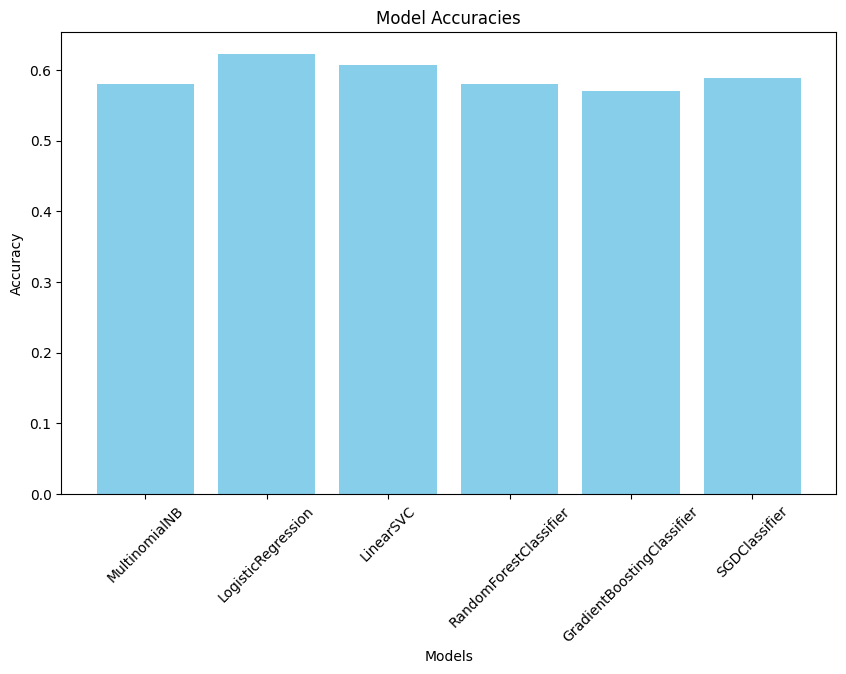

In [20]:
import matplotlib.pyplot as plt

accuracy_scores = []

for model in models:
    # Check if the model can handle sparse data
    if 'sparse' in model.get_params().get('input', ''):
        # Fit the model on sparse data
        model.fit(X_train, y_train)
    else:
        # Convert sparse matrix to dense array
        model.fit(X_train.toarray(), y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val.toarray() if not hasattr(model, 'predict_proba') else X_val)


    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Append the accuracy to our list
    accuracy_scores.append(accuracy)

# plot the accuracies
plt.figure(figsize=(10, 6))
model_names = [type(model).__name__ for model in models]
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.title('Model Accuracies')
plt.show()


In [22]:
accuracy_scores

[0.5807106598984771,
 0.6223350253807106,
 0.6071065989847716,
 0.5796954314720812,
 0.5705583756345177,
 0.5888324873096447]

test

In [28]:
# Preprocess the test data
df_test['Text'] = df_test['Text'].apply(clean_text)
# Transform the test data using the best TF-IDF parameters from the trained vectorizer
X_test_tfidf = vectorizer.transform(df_test['Text'])

# Make predictions on the test data using the trained pipeline
test_predictions = grid_search_tfidf.predict(df_test['Text'])

# Output the predictions
print(test_predictions)



['OTHER' 'HAPPY' 'ANGRY' 'HAPPY' 'OTHER' 'ANGRY' 'SAD' 'HAPPY' 'OTHER'
 'HAPPY' 'OTHER' 'SAD' 'HAPPY' 'ANGRY' 'OTHER' 'OTHER' 'HAPPY' 'HAPPY'
 'HAPPY' 'HAPPY' 'OTHER' 'ANGRY' 'OTHER' 'OTHER' 'OTHER' 'HAPPY' 'OTHER'
 'OTHER' 'OTHER' 'ANGRY' 'HAPPY' 'SAD' 'ANGRY' 'OTHER' 'OTHER' 'HAPPY'
 'ANGRY' 'SAD' 'OTHER' 'HAPPY' 'HAPPY' 'OTHER' 'OTHER' 'HAPPY' 'OTHER'
 'SAD' 'HAPPY' 'OTHER' 'FEAR' 'HAPPY' 'OTHER' 'OTHER' 'HAPPY' 'HAPPY'
 'OTHER' 'HAPPY' 'HAPPY' 'OTHER' 'OTHER' 'OTHER' 'OTHER' 'OTHER' 'ANGRY'
 'HAPPY' 'HAPPY' 'HAPPY' 'HAPPY' 'OTHER' 'OTHER' 'HAPPY' 'HAPPY' 'HAPPY'
 'OTHER' 'HAPPY' 'SAD' 'OTHER' 'OTHER' 'HAPPY' 'OTHER' 'OTHER' 'OTHER'
 'HAPPY' 'OTHER' 'HAPPY' 'HAPPY' 'SAD' 'OTHER' 'ANGRY' 'HAPPY' 'OTHER'
 'HAPPY' 'OTHER' 'OTHER' 'FEAR' 'HAPPY' 'SAD' 'OTHER' 'HAPPY' 'OTHER'
 'ANGRY' 'SAD' 'SAD' 'HAPPY' 'FEAR' 'HAPPY' 'SAD' 'FEAR' 'ANGRY' 'OTHER'
 'OTHER' 'SAD' 'HAPPY' 'FEAR' 'HAPPY' 'SAD' 'OTHER' 'OTHER' 'OTHER'
 'OTHER' 'SAD' 'OTHER' 'FEAR' 'HAPPY' 'SAD' 'OTHER' 'SAD' 'ANGRY' 'SAD'
 '